In [7]:
import torch
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import sklearn
import networkx as nx
import random

# 1. Model definition

In [3]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = torch.nn.Linear(input_dim, hidden_dim)
        self.decoder = torch.nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        encoded = torch.sigmoid(self.encoder(x))
        decoded = torch.sigmoid(self.decoder(encoded))
        return encoded, decoded

In [4]:
class GraphEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        self.autoencoders = torch.nn.ModuleList()
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.autoencoders.append(AutoEncoder(prev_dim, hidden_dim))
            prev_dim = hidden_dim

    def forward(self, x):
        for autoencoder in self.autoencoders:
            x = torch.sigmoid(autoencoder.encoder(x))
        encoded = x
        for autoencoder in reversed(self.autoencoders):
            x = torch.sigmoid(autoencoder.decoder(x))
        decoded = x
        return encoded, decoded

# 2. Kickstart test

In [5]:
# Loading the dataset
x_train, y = sklearn.datasets.load_digits(return_X_y=True, as_frame=False)
x_train = x_train / 255.0
x_train = torch.tensor(x_train, dtype=torch.float32)

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print("device:", DEVICE)
BATCH_SIZE = 256
HIDDEN_DIMS =  [32, 16, 8]

# Create the model
model = GraphEncoder(input_dim=x_train.shape[1], hidden_dims=HIDDEN_DIMS).to(DEVICE)

# Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Create initial dataloader
x_train = x_train.to(DEVICE)
current_x_train = x_train.clone().detach()
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(current_x_train),
    batch_size=BATCH_SIZE,
    shuffle=True
)
dataloader_iter = iter(dataloader)

# Set some training parameters
NB_EPOCHS_PER_LAYER = 5000
nb_train_iters = NB_EPOCHS_PER_LAYER * len(dataloader)
rho=0.01
beta=1.0

# Launch the training loop
# For each layer in the stacked autoencoder: train the layer
for layer_number in range(len(model.autoencoders)):
    for _ in tqdm.tqdm(range(nb_train_iters), desc=f"layer: {layer_number}"):
        try:
            (x_batch,) = next(dataloader_iter)
        except StopIteration:
            dataloader_iter = iter(dataloader)
            (x_batch,) = next(dataloader_iter)
        optimizer.zero_grad()
        encoded, decoded = model.autoencoders[layer_number](x_batch)
        loss_1 = torch.nn.functional.mse_loss(decoded, x_batch, reduction='sum')
        rho_hat = torch.mean(encoded, dim=0)
        loss_2 = torch.sum(rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat)))
        loss = loss_1 + beta * loss_2
        loss.backward()
        optimizer.step()

    # Create new dataloader on the latent representations
    with torch.no_grad():
        latent_x_train, _ = model.autoencoders[layer_number](current_x_train)
        dataloader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(latent_x_train),
            batch_size=BATCH_SIZE,
            shuffle=True
        )
        dataloader_iter = iter(dataloader)
        current_x_train = latent_x_train.clone()

device: cuda


layer: 2: 100%|██████████| 40000/40000 [01:10<00:00, 563.55it/s]


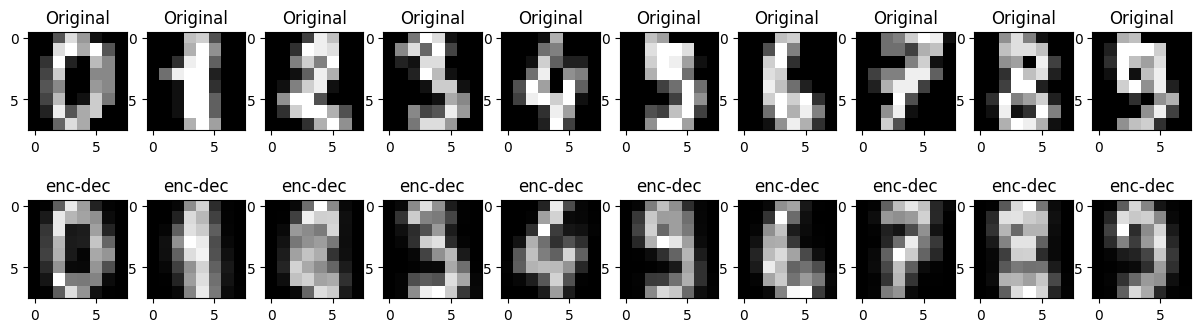

In [ ]:
with torch.no_grad():
    encoded, decoded = model(x_train)
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for column in range(10):
    axes[0, column].imshow(x_train[column].to("cpu").reshape(8, 8), cmap='gray')
    axes[0, column].set_title("Original")
    axes[1, column].imshow(decoded[column].to("cpu").reshape(8, 8), cmap='gray')
    axes[1, column].set_title("enc-dec")
plt.show()

# 3. Test on paper benchmarks (wine and 20-newsgroup)

In [95]:
# Loading Wine
x, y= sklearn.datasets.load_wine(return_X_y=True, as_frame=False)
x = sklearn.preprocessing.MinMaxScaler().fit_transform(x)
s = sklearn.metrics.pairwise.cosine_similarity(x, x)
nts = s / np.sum(s, axis=1, keepdims=True)
print("[*] nts.shape:", nts.shape)
print("[*] number of clusters:", len(set(y)))
cum = 0
NB_KMEANS_TESTS = 1
random.seed(0)
for _ in tqdm.tqdm(range(NB_KMEANS_TESTS)):
    kmeans = sklearn.cluster.KMeans(n_clusters=len(set(y)), algorithm="lloyd", random_state=random.randint(0, 10000))
    y_pred_origspace = kmeans.fit_predict(nts)
    cum += sklearn.metrics.normalized_mutual_info_score(y, y_pred_origspace)
print("[*] original space average nmi:", cum / NB_KMEANS_TESTS)

[*] nts.shape: (178, 178)
[*] number of clusters: 3


100%|██████████| 1/1 [00:00<00:00, 296.84it/s]

[*] original space average nmi: 0.6351524906645799


In [15]:
torch.manual_seed(0)
np.random.seed(0)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu'); print("device:", DEVICE)
BATCH_SIZE = 178
HIDDEN_DIMS =  [128, 64]

# Create the model
model = GraphEncoder(input_dim=nts.shape[1], hidden_dims=HIDDEN_DIMS).to(DEVICE)

# Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Create initial dataloader
x_train = torch.tensor(nts, dtype=torch.float32).to(DEVICE)
current_x_train = x_train.clone()
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(current_x_train),
    batch_size=BATCH_SIZE,
    shuffle=True
)
dataloader_iter = iter(dataloader)

# Set some training parameters
NB_EPOCHS_PER_LAYER = 1000
nb_train_iters = NB_EPOCHS_PER_LAYER * len(dataloader)
rho=0.01
beta=1.0

# Launch the training loop
# For each layer in the stacked autoencoder: train the layer
for layer_number in range(len(model.autoencoders)):
    for _ in tqdm.tqdm(range(nb_train_iters), desc=f"layer: {layer_number+1}"):
        try:
            (x_batch,) = next(dataloader_iter)
        except StopIteration:
            dataloader_iter = iter(dataloader)
            (x_batch,) = next(dataloader_iter)
        optimizer.zero_grad()
        encoded, decoded = model.autoencoders[layer_number](x_batch)
        loss_1 = torch.nn.functional.mse_loss(decoded, x_batch, reduction='sum')
        rho_hat = torch.mean(encoded, dim=0)
        loss_2 = torch.sum(rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat)))
        loss = loss_1 + beta * loss_2
        loss.backward()
        optimizer.step()

    # Create new dataloader on the latent representations
    with torch.no_grad():
        latent_x_train, _ = model.autoencoders[layer_number](current_x_train)
        dataloader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(latent_x_train),
            batch_size=BATCH_SIZE,
            shuffle=True
        )
        dataloader_iter = iter(dataloader)
        current_x_train = latent_x_train.clone()

device: cpu


layer: 2: 100%|██████████| 1000/1000 [00:01<00:00, 723.04it/s]


In [96]:
# Test on the latent space
with torch.no_grad():
    latent, _ = model(x_train)
cum = 0
NB_KMEANS_TESTS = 1000
for _ in tqdm.tqdm(range(NB_KMEANS_TESTS)):
    kmeans = sklearn.cluster.KMeans(n_clusters=len(set(y)), algorithm="lloyd")
    y_pred_latent = kmeans.fit_predict(latent.to('cpu'))
    cum += sklearn.metrics.normalized_mutual_info_score(y, y_pred_latent)
print("[*] latent space nmi:", cum / NB_KMEANS_TESTS)

100%|██████████| 1000/1000 [00:02<00:00, 486.93it/s]

[*] latent space nmi: 0.4866856828982827
